# Deep Convolutional GANs

In this notebook, we'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, here's the [original paper](https://arxiv.org/pdf/1511.06434.pdf).

We'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: data: File exists


## Getting the data

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:10, 16.9MB/s]                              
SVHN Training Set: 64.3MB [00:04, 15.0MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

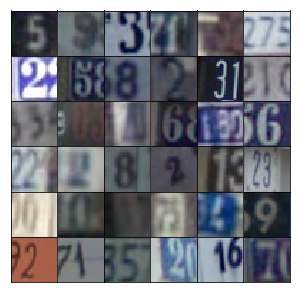

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), self.scaler(y)

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

Keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)       
        return out

## Discriminator

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)  
        
        return out, logits

## Model Loss

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined above to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network.

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 5, 10, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.001
batch_size = 256
epochs = 10
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/10... Discriminator Loss: 1.6929... Generator Loss: 20.7281
Epoch 1/10... Discriminator Loss: 0.1287... Generator Loss: 3.0395
Epoch 1/10... Discriminator Loss: 0.0244... Generator Loss: 9.1198
Epoch 1/10... Discriminator Loss: 0.9187... Generator Loss: 5.2324
Epoch 1/10... Discriminator Loss: 1.3895... Generator Loss: 0.5599
Epoch 1/10... Discriminator Loss: 1.4957... Generator Loss: 3.6262
Epoch 1/10... Discriminator Loss: 0.5491... Generator Loss: 1.4616
Epoch 1/10... Discriminator Loss: 0.4166... Generator Loss: 1.6283
Epoch 1/10... Discriminator Loss: 0.9555... Generator Loss: 1.3878
Epoch 1/10... Discriminator Loss: 0.4504... Generator Loss: 1.5919


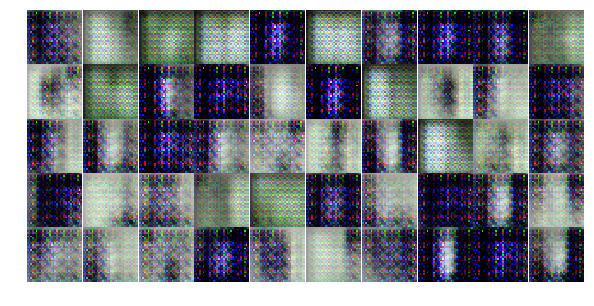

Epoch 1/10... Discriminator Loss: 0.5959... Generator Loss: 1.1830
Epoch 1/10... Discriminator Loss: 1.8933... Generator Loss: 2.3606
Epoch 1/10... Discriminator Loss: 0.8894... Generator Loss: 2.6953
Epoch 1/10... Discriminator Loss: 0.7460... Generator Loss: 2.0223
Epoch 1/10... Discriminator Loss: 0.8956... Generator Loss: 1.2215
Epoch 1/10... Discriminator Loss: 0.3027... Generator Loss: 2.1844
Epoch 1/10... Discriminator Loss: 1.3045... Generator Loss: 0.8259
Epoch 1/10... Discriminator Loss: 0.7163... Generator Loss: 2.2877
Epoch 1/10... Discriminator Loss: 1.4861... Generator Loss: 1.2619
Epoch 1/10... Discriminator Loss: 1.1517... Generator Loss: 1.0230


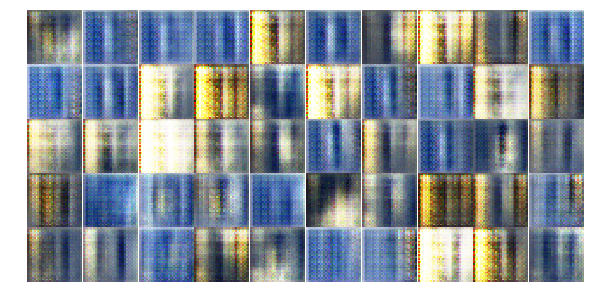

Epoch 1/10... Discriminator Loss: 0.9736... Generator Loss: 0.9993
Epoch 1/10... Discriminator Loss: 1.2343... Generator Loss: 1.2622
Epoch 1/10... Discriminator Loss: 1.2706... Generator Loss: 0.5147
Epoch 1/10... Discriminator Loss: 0.7362... Generator Loss: 1.3528
Epoch 1/10... Discriminator Loss: 0.5759... Generator Loss: 1.6616
Epoch 1/10... Discriminator Loss: 2.6770... Generator Loss: 0.5944
Epoch 1/10... Discriminator Loss: 0.7835... Generator Loss: 1.1496
Epoch 1/10... Discriminator Loss: 1.3189... Generator Loss: 1.0339
Epoch 2/10... Discriminator Loss: 1.5053... Generator Loss: 2.8462
Epoch 2/10... Discriminator Loss: 0.6140... Generator Loss: 1.2087


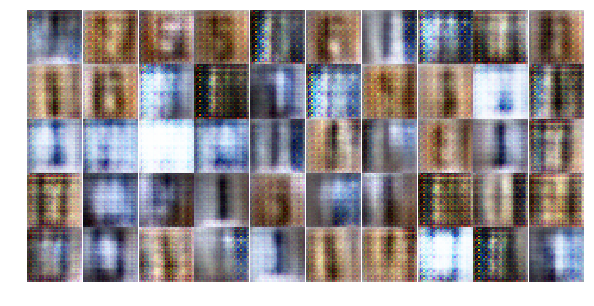

Epoch 2/10... Discriminator Loss: 1.4299... Generator Loss: 1.0315
Epoch 2/10... Discriminator Loss: 1.8606... Generator Loss: 1.6369
Epoch 2/10... Discriminator Loss: 0.8010... Generator Loss: 1.1596
Epoch 2/10... Discriminator Loss: 1.1668... Generator Loss: 0.7595
Epoch 2/10... Discriminator Loss: 1.0102... Generator Loss: 0.7516
Epoch 2/10... Discriminator Loss: 0.7602... Generator Loss: 1.3975
Epoch 2/10... Discriminator Loss: 1.2274... Generator Loss: 0.6140
Epoch 2/10... Discriminator Loss: 3.2515... Generator Loss: 0.2089
Epoch 2/10... Discriminator Loss: 0.5767... Generator Loss: 1.0832
Epoch 2/10... Discriminator Loss: 1.0728... Generator Loss: 1.5771


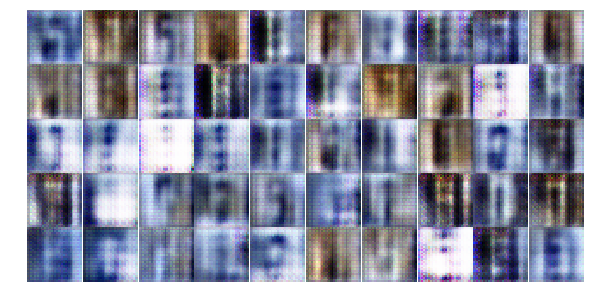

Epoch 2/10... Discriminator Loss: 1.3791... Generator Loss: 0.7620
Epoch 2/10... Discriminator Loss: 1.4566... Generator Loss: 0.6345
Epoch 2/10... Discriminator Loss: 1.1165... Generator Loss: 0.9375
Epoch 2/10... Discriminator Loss: 1.0747... Generator Loss: 1.0147
Epoch 2/10... Discriminator Loss: 1.3239... Generator Loss: 0.9011
Epoch 2/10... Discriminator Loss: 1.3790... Generator Loss: 0.8754
Epoch 2/10... Discriminator Loss: 0.9626... Generator Loss: 1.4236
Epoch 2/10... Discriminator Loss: 1.2865... Generator Loss: 0.4651
Epoch 2/10... Discriminator Loss: 1.3787... Generator Loss: 0.8014
Epoch 2/10... Discriminator Loss: 0.9375... Generator Loss: 1.1995


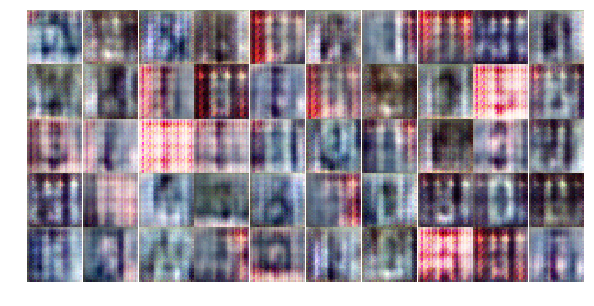

Epoch 2/10... Discriminator Loss: 1.2960... Generator Loss: 0.6614
Epoch 2/10... Discriminator Loss: 1.5653... Generator Loss: 0.7552
Epoch 2/10... Discriminator Loss: 1.4141... Generator Loss: 2.1510
Epoch 2/10... Discriminator Loss: 1.4287... Generator Loss: 0.6952
Epoch 2/10... Discriminator Loss: 1.2913... Generator Loss: 0.7727
Epoch 2/10... Discriminator Loss: 1.3319... Generator Loss: 0.8773
Epoch 2/10... Discriminator Loss: 1.1918... Generator Loss: 0.8688
Epoch 3/10... Discriminator Loss: 1.2733... Generator Loss: 0.8502
Epoch 3/10... Discriminator Loss: 1.3586... Generator Loss: 1.2407
Epoch 3/10... Discriminator Loss: 1.0327... Generator Loss: 1.0601


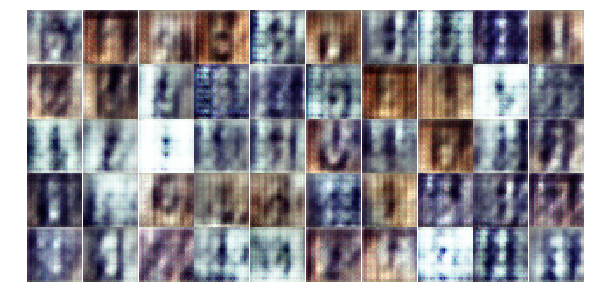

Epoch 3/10... Discriminator Loss: 1.4345... Generator Loss: 0.4497
Epoch 3/10... Discriminator Loss: 1.2322... Generator Loss: 0.9129
Epoch 3/10... Discriminator Loss: 1.6925... Generator Loss: 0.8198
Epoch 3/10... Discriminator Loss: 0.7318... Generator Loss: 0.9616
Epoch 3/10... Discriminator Loss: 1.2932... Generator Loss: 0.6684
Epoch 3/10... Discriminator Loss: 1.2086... Generator Loss: 0.8020
Epoch 3/10... Discriminator Loss: 1.2522... Generator Loss: 0.7383
Epoch 3/10... Discriminator Loss: 1.3029... Generator Loss: 0.6774
Epoch 3/10... Discriminator Loss: 1.6660... Generator Loss: 0.4919
Epoch 3/10... Discriminator Loss: 1.1883... Generator Loss: 0.8270


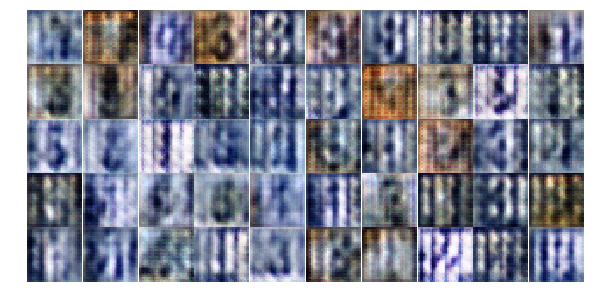

Epoch 3/10... Discriminator Loss: 1.8406... Generator Loss: 2.0169
Epoch 3/10... Discriminator Loss: 0.9898... Generator Loss: 1.1111
Epoch 3/10... Discriminator Loss: 1.2670... Generator Loss: 0.6039
Epoch 3/10... Discriminator Loss: 0.7824... Generator Loss: 1.0102
Epoch 3/10... Discriminator Loss: 1.3748... Generator Loss: 1.0806
Epoch 3/10... Discriminator Loss: 1.2725... Generator Loss: 0.8060
Epoch 3/10... Discriminator Loss: 1.1567... Generator Loss: 0.8749
Epoch 3/10... Discriminator Loss: 1.3892... Generator Loss: 0.6935
Epoch 3/10... Discriminator Loss: 1.2022... Generator Loss: 1.0323
Epoch 3/10... Discriminator Loss: 1.1329... Generator Loss: 0.9098


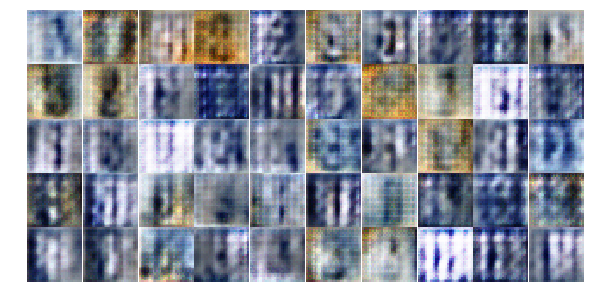

Epoch 3/10... Discriminator Loss: 1.4023... Generator Loss: 0.8016
Epoch 3/10... Discriminator Loss: 1.3050... Generator Loss: 0.7277
Epoch 3/10... Discriminator Loss: 1.2538... Generator Loss: 0.8556
Epoch 3/10... Discriminator Loss: 1.0606... Generator Loss: 0.9508
Epoch 3/10... Discriminator Loss: 1.7863... Generator Loss: 0.3976
Epoch 3/10... Discriminator Loss: 0.9948... Generator Loss: 1.3053
Epoch 4/10... Discriminator Loss: 1.0617... Generator Loss: 1.3306
Epoch 4/10... Discriminator Loss: 1.1709... Generator Loss: 1.3046
Epoch 4/10... Discriminator Loss: 1.2410... Generator Loss: 0.7781
Epoch 4/10... Discriminator Loss: 1.3329... Generator Loss: 0.8090


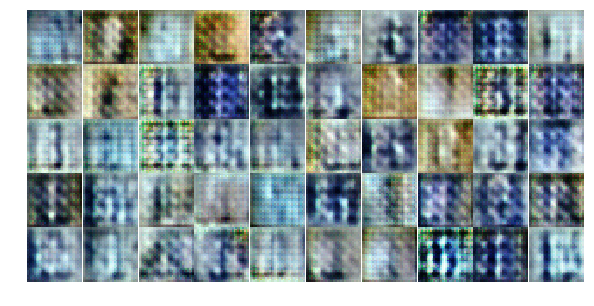

Epoch 4/10... Discriminator Loss: 1.4061... Generator Loss: 0.6757
Epoch 4/10... Discriminator Loss: 1.3150... Generator Loss: 0.7943
Epoch 4/10... Discriminator Loss: 1.1322... Generator Loss: 0.6140
Epoch 4/10... Discriminator Loss: 1.3137... Generator Loss: 1.0657
Epoch 4/10... Discriminator Loss: 1.2272... Generator Loss: 0.8331
Epoch 4/10... Discriminator Loss: 1.0872... Generator Loss: 0.8771
Epoch 4/10... Discriminator Loss: 0.9608... Generator Loss: 0.9680
Epoch 4/10... Discriminator Loss: 1.2418... Generator Loss: 0.7985
Epoch 4/10... Discriminator Loss: 1.1724... Generator Loss: 0.8023
Epoch 4/10... Discriminator Loss: 1.1055... Generator Loss: 1.1207


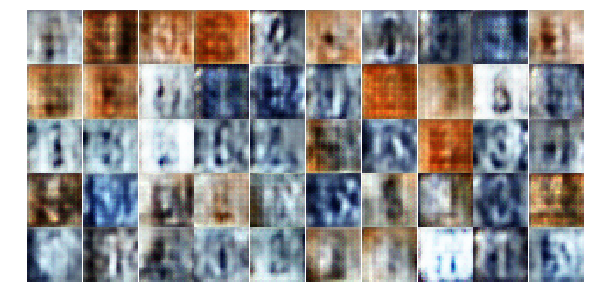

Epoch 4/10... Discriminator Loss: 1.2044... Generator Loss: 0.8949
Epoch 4/10... Discriminator Loss: 1.1967... Generator Loss: 0.6363
Epoch 4/10... Discriminator Loss: 1.2517... Generator Loss: 0.7019
Epoch 4/10... Discriminator Loss: 1.4270... Generator Loss: 0.7027
Epoch 4/10... Discriminator Loss: 1.2431... Generator Loss: 0.8977
Epoch 4/10... Discriminator Loss: 1.4290... Generator Loss: 0.7820
Epoch 4/10... Discriminator Loss: 1.2615... Generator Loss: 0.8241
Epoch 4/10... Discriminator Loss: 1.4480... Generator Loss: 0.7529
Epoch 4/10... Discriminator Loss: 1.4334... Generator Loss: 0.5850
Epoch 4/10... Discriminator Loss: 1.2966... Generator Loss: 0.5421


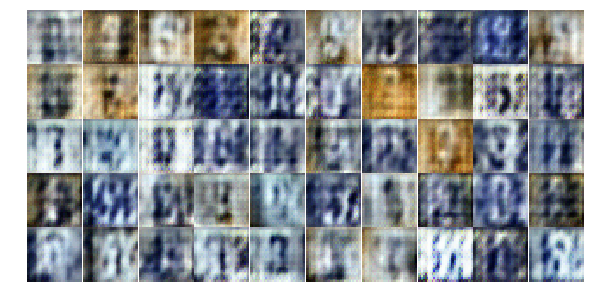

Epoch 4/10... Discriminator Loss: 0.9956... Generator Loss: 1.1769
Epoch 4/10... Discriminator Loss: 1.1452... Generator Loss: 1.2122
Epoch 4/10... Discriminator Loss: 1.1134... Generator Loss: 0.6404
Epoch 4/10... Discriminator Loss: 1.4906... Generator Loss: 0.6386
Epoch 5/10... Discriminator Loss: 0.9839... Generator Loss: 0.9638
Epoch 5/10... Discriminator Loss: 1.2486... Generator Loss: 0.8064
Epoch 5/10... Discriminator Loss: 1.6779... Generator Loss: 0.7062
Epoch 5/10... Discriminator Loss: 1.2986... Generator Loss: 0.7171
Epoch 5/10... Discriminator Loss: 1.2204... Generator Loss: 0.8992
Epoch 5/10... Discriminator Loss: 1.5532... Generator Loss: 1.0704


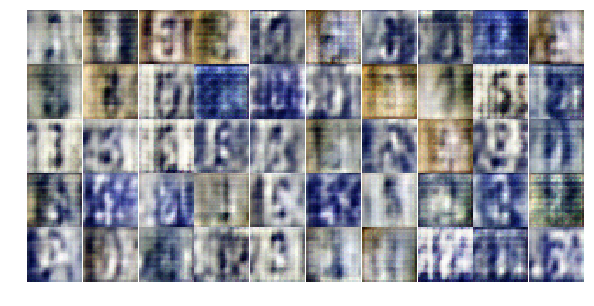

Epoch 5/10... Discriminator Loss: 1.3397... Generator Loss: 0.9413
Epoch 5/10... Discriminator Loss: 1.2986... Generator Loss: 0.6987
Epoch 5/10... Discriminator Loss: 1.2955... Generator Loss: 0.7972
Epoch 5/10... Discriminator Loss: 1.2476... Generator Loss: 0.8212
Epoch 5/10... Discriminator Loss: 1.1318... Generator Loss: 1.0180
Epoch 5/10... Discriminator Loss: 1.2810... Generator Loss: 0.7034
Epoch 5/10... Discriminator Loss: 0.8197... Generator Loss: 1.8325
Epoch 5/10... Discriminator Loss: 1.2824... Generator Loss: 0.7500
Epoch 5/10... Discriminator Loss: 1.1593... Generator Loss: 0.7910
Epoch 5/10... Discriminator Loss: 1.4511... Generator Loss: 0.6828


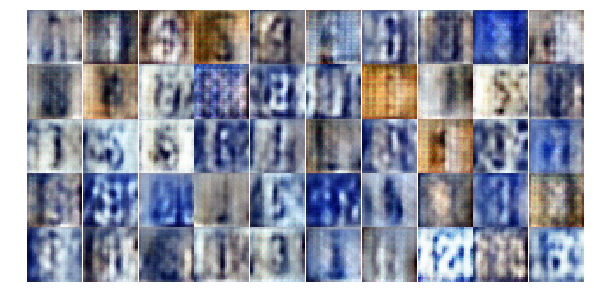

Epoch 5/10... Discriminator Loss: 0.9884... Generator Loss: 1.0475
Epoch 5/10... Discriminator Loss: 1.4386... Generator Loss: 0.3955
Epoch 5/10... Discriminator Loss: 1.5253... Generator Loss: 0.6116
Epoch 5/10... Discriminator Loss: 1.2357... Generator Loss: 0.9201
Epoch 5/10... Discriminator Loss: 1.2620... Generator Loss: 1.0328
Epoch 5/10... Discriminator Loss: 0.7312... Generator Loss: 1.0930
Epoch 5/10... Discriminator Loss: 1.2020... Generator Loss: 0.8287
Epoch 5/10... Discriminator Loss: 1.2310... Generator Loss: 0.7298
Epoch 5/10... Discriminator Loss: 1.2148... Generator Loss: 0.8610
Epoch 5/10... Discriminator Loss: 1.1567... Generator Loss: 0.9398


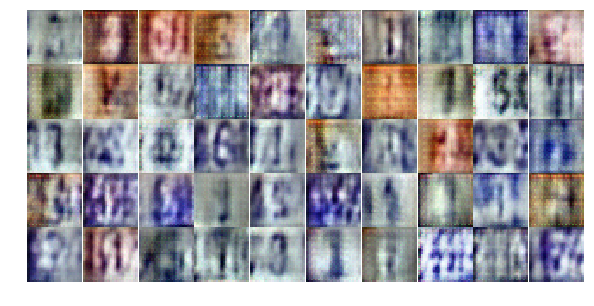

Epoch 5/10... Discriminator Loss: 1.4890... Generator Loss: 0.4682
Epoch 5/10... Discriminator Loss: 1.0195... Generator Loss: 1.0446
Epoch 5/10... Discriminator Loss: 0.5609... Generator Loss: 1.0648
Epoch 6/10... Discriminator Loss: 1.2728... Generator Loss: 1.3210
Epoch 6/10... Discriminator Loss: 1.2016... Generator Loss: 0.9495
Epoch 6/10... Discriminator Loss: 1.4559... Generator Loss: 0.5406
Epoch 6/10... Discriminator Loss: 1.2754... Generator Loss: 0.6495
Epoch 6/10... Discriminator Loss: 0.9444... Generator Loss: 1.3025
Epoch 6/10... Discriminator Loss: 1.0983... Generator Loss: 0.9757
Epoch 6/10... Discriminator Loss: 1.0467... Generator Loss: 1.2126


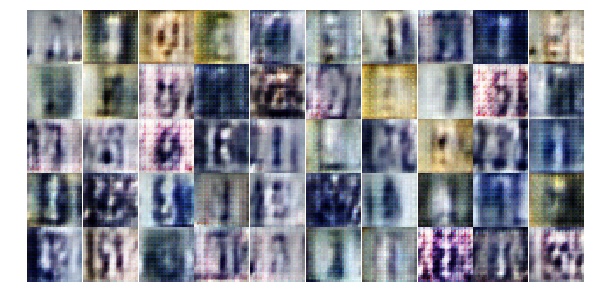

Epoch 6/10... Discriminator Loss: 1.1382... Generator Loss: 1.4005
Epoch 6/10... Discriminator Loss: 1.0658... Generator Loss: 0.8367
Epoch 6/10... Discriminator Loss: 1.1129... Generator Loss: 0.6747
Epoch 6/10... Discriminator Loss: 0.6013... Generator Loss: 1.3682
Epoch 6/10... Discriminator Loss: 0.9149... Generator Loss: 1.8047
Epoch 6/10... Discriminator Loss: 0.6403... Generator Loss: 1.3458
Epoch 6/10... Discriminator Loss: 1.0780... Generator Loss: 1.1501
Epoch 6/10... Discriminator Loss: 1.0907... Generator Loss: 0.8898
Epoch 6/10... Discriminator Loss: 1.4093... Generator Loss: 0.8687
Epoch 6/10... Discriminator Loss: 1.0445... Generator Loss: 0.8189


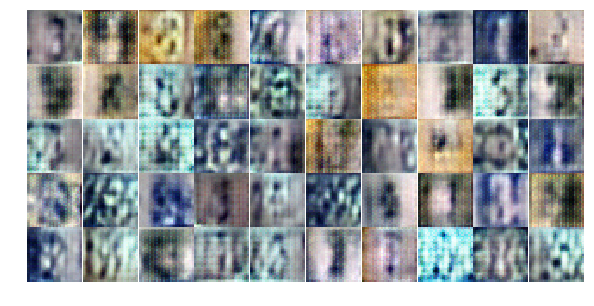

Epoch 6/10... Discriminator Loss: 1.1515... Generator Loss: 0.8456
Epoch 6/10... Discriminator Loss: 1.0498... Generator Loss: 1.1529
Epoch 6/10... Discriminator Loss: 0.8177... Generator Loss: 1.5327
Epoch 6/10... Discriminator Loss: 1.0220... Generator Loss: 0.9736
Epoch 6/10... Discriminator Loss: 0.9059... Generator Loss: 1.1438
Epoch 6/10... Discriminator Loss: 0.9187... Generator Loss: 1.1754
Epoch 6/10... Discriminator Loss: 1.0296... Generator Loss: 1.4940
Epoch 6/10... Discriminator Loss: 0.9392... Generator Loss: 2.8324
Epoch 6/10... Discriminator Loss: 1.3975... Generator Loss: 2.0032
Epoch 6/10... Discriminator Loss: 1.0531... Generator Loss: 0.9061


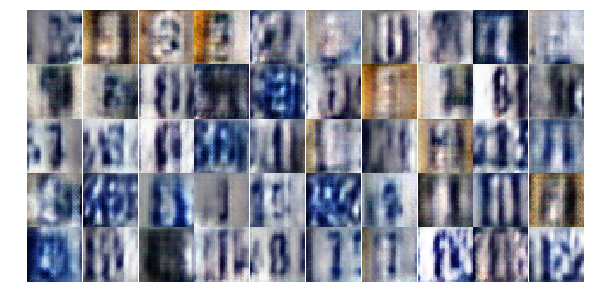

Epoch 6/10... Discriminator Loss: 0.9693... Generator Loss: 2.4656
Epoch 6/10... Discriminator Loss: 0.3254... Generator Loss: 2.0823
Epoch 7/10... Discriminator Loss: 0.9959... Generator Loss: 1.1486
Epoch 7/10... Discriminator Loss: 0.7945... Generator Loss: 1.4378
Epoch 7/10... Discriminator Loss: 1.0423... Generator Loss: 0.8944
Epoch 7/10... Discriminator Loss: 0.5921... Generator Loss: 1.8742
Epoch 7/10... Discriminator Loss: 0.7542... Generator Loss: 0.8857
Epoch 7/10... Discriminator Loss: 0.9176... Generator Loss: 1.4273
Epoch 7/10... Discriminator Loss: 1.0660... Generator Loss: 0.8624
Epoch 7/10... Discriminator Loss: 1.6845... Generator Loss: 0.3241


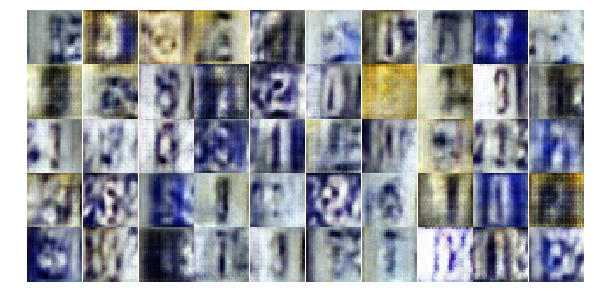

Epoch 7/10... Discriminator Loss: 0.9764... Generator Loss: 1.2400
Epoch 7/10... Discriminator Loss: 0.9135... Generator Loss: 1.0484
Epoch 7/10... Discriminator Loss: 1.1318... Generator Loss: 2.4885
Epoch 7/10... Discriminator Loss: 0.7975... Generator Loss: 1.4335
Epoch 7/10... Discriminator Loss: 1.0088... Generator Loss: 2.0276
Epoch 7/10... Discriminator Loss: 1.2536... Generator Loss: 1.9047
Epoch 7/10... Discriminator Loss: 1.3482... Generator Loss: 0.8222
Epoch 7/10... Discriminator Loss: 1.3180... Generator Loss: 1.2531
Epoch 7/10... Discriminator Loss: 1.1944... Generator Loss: 1.3791
Epoch 7/10... Discriminator Loss: 0.8153... Generator Loss: 1.6637


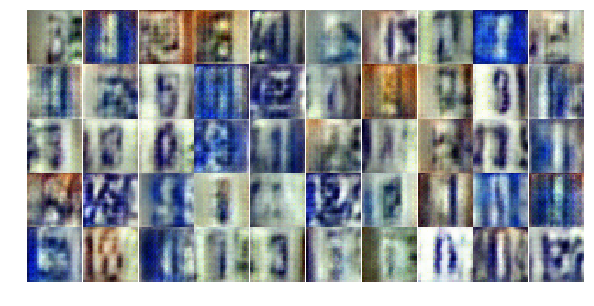

Epoch 7/10... Discriminator Loss: 1.1060... Generator Loss: 2.1344
Epoch 7/10... Discriminator Loss: 0.3744... Generator Loss: 2.0800
Epoch 7/10... Discriminator Loss: 0.3697... Generator Loss: 1.7508
Epoch 7/10... Discriminator Loss: 0.2000... Generator Loss: 3.1500
Epoch 7/10... Discriminator Loss: 0.5234... Generator Loss: 2.6029
Epoch 7/10... Discriminator Loss: 2.0014... Generator Loss: 0.7390
Epoch 7/10... Discriminator Loss: 1.2356... Generator Loss: 0.9491
Epoch 7/10... Discriminator Loss: 1.3290... Generator Loss: 0.5468
Epoch 7/10... Discriminator Loss: 1.2573... Generator Loss: 0.7244
Epoch 7/10... Discriminator Loss: 1.1810... Generator Loss: 1.0619


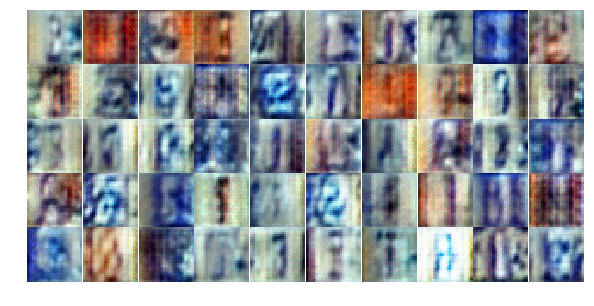

Epoch 8/10... Discriminator Loss: 1.5721... Generator Loss: 0.3653
Epoch 8/10... Discriminator Loss: 0.9146... Generator Loss: 1.3290
Epoch 8/10... Discriminator Loss: 0.7206... Generator Loss: 0.9757
Epoch 8/10... Discriminator Loss: 0.3489... Generator Loss: 1.7430
Epoch 8/10... Discriminator Loss: 0.2125... Generator Loss: 2.7000
Epoch 8/10... Discriminator Loss: 1.3880... Generator Loss: 0.4603
Epoch 8/10... Discriminator Loss: 1.0744... Generator Loss: 0.7020
Epoch 8/10... Discriminator Loss: 0.9278... Generator Loss: 1.3601
Epoch 8/10... Discriminator Loss: 1.5101... Generator Loss: 0.5654
Epoch 8/10... Discriminator Loss: 0.9642... Generator Loss: 1.0499


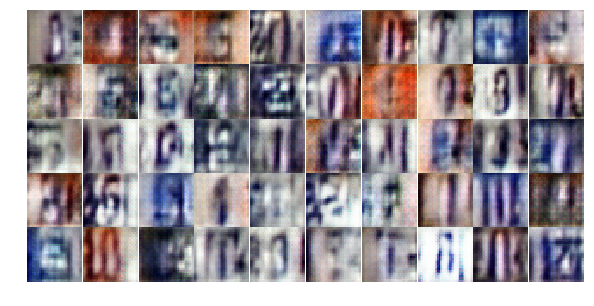

Epoch 8/10... Discriminator Loss: 0.4895... Generator Loss: 2.8396
Epoch 8/10... Discriminator Loss: 1.6671... Generator Loss: 0.3697
Epoch 8/10... Discriminator Loss: 1.2556... Generator Loss: 1.1877
Epoch 8/10... Discriminator Loss: 0.6456... Generator Loss: 1.5973
Epoch 8/10... Discriminator Loss: 1.4263... Generator Loss: 0.4507
Epoch 8/10... Discriminator Loss: 0.4351... Generator Loss: 3.3349
Epoch 8/10... Discriminator Loss: 0.5775... Generator Loss: 1.8508
Epoch 8/10... Discriminator Loss: 1.5153... Generator Loss: 0.3397
Epoch 8/10... Discriminator Loss: 0.6721... Generator Loss: 1.2007
Epoch 8/10... Discriminator Loss: 0.2277... Generator Loss: 3.0711


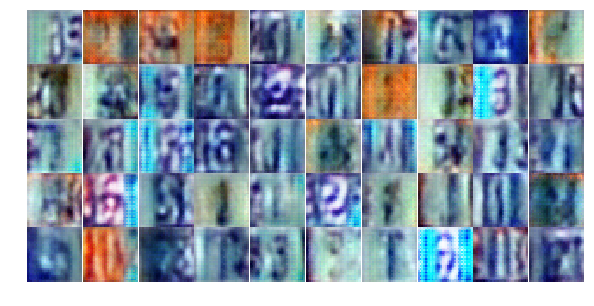

Epoch 8/10... Discriminator Loss: 0.8360... Generator Loss: 0.9594
Epoch 8/10... Discriminator Loss: 1.1750... Generator Loss: 1.6541
Epoch 8/10... Discriminator Loss: 1.2954... Generator Loss: 0.6170
Epoch 8/10... Discriminator Loss: 1.1817... Generator Loss: 0.6696
Epoch 8/10... Discriminator Loss: 1.1313... Generator Loss: 0.9697
Epoch 8/10... Discriminator Loss: 1.2477... Generator Loss: 1.1005
Epoch 8/10... Discriminator Loss: 0.9668... Generator Loss: 0.9517
Epoch 8/10... Discriminator Loss: 1.0560... Generator Loss: 0.9964
Epoch 8/10... Discriminator Loss: 1.0027... Generator Loss: 1.6832
Epoch 9/10... Discriminator Loss: 1.3002... Generator Loss: 1.1911


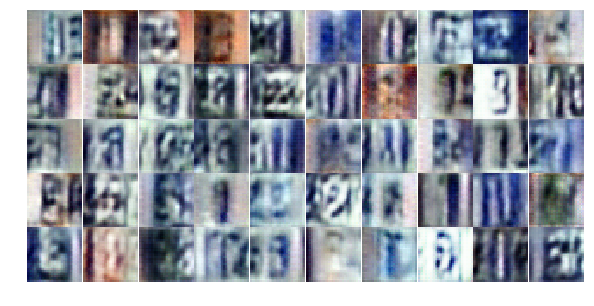

Epoch 9/10... Discriminator Loss: 1.2635... Generator Loss: 0.5794
Epoch 9/10... Discriminator Loss: 0.9200... Generator Loss: 1.2547
Epoch 9/10... Discriminator Loss: 1.1719... Generator Loss: 1.4610
Epoch 9/10... Discriminator Loss: 1.2776... Generator Loss: 0.5823
Epoch 9/10... Discriminator Loss: 1.3581... Generator Loss: 0.5971
Epoch 9/10... Discriminator Loss: 1.2220... Generator Loss: 1.1702
Epoch 9/10... Discriminator Loss: 1.3824... Generator Loss: 0.6608
Epoch 9/10... Discriminator Loss: 1.0306... Generator Loss: 0.8859
Epoch 9/10... Discriminator Loss: 1.2383... Generator Loss: 1.0823
Epoch 9/10... Discriminator Loss: 0.9523... Generator Loss: 1.2773


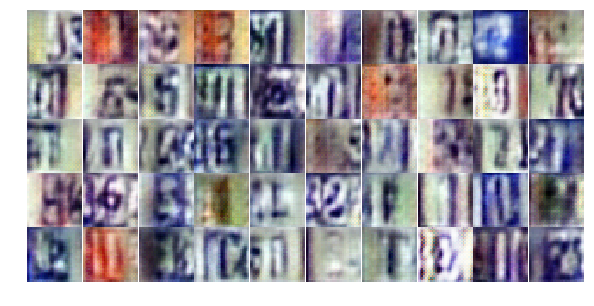

Epoch 9/10... Discriminator Loss: 1.5720... Generator Loss: 0.3782
Epoch 9/10... Discriminator Loss: 1.5028... Generator Loss: 0.8397
Epoch 9/10... Discriminator Loss: 1.0391... Generator Loss: 1.2719
Epoch 9/10... Discriminator Loss: 1.1526... Generator Loss: 1.1530
Epoch 9/10... Discriminator Loss: 1.2454... Generator Loss: 0.6927
Epoch 9/10... Discriminator Loss: 1.0531... Generator Loss: 0.8020
Epoch 9/10... Discriminator Loss: 1.2388... Generator Loss: 0.5965
Epoch 9/10... Discriminator Loss: 1.2187... Generator Loss: 0.6874
Epoch 9/10... Discriminator Loss: 1.2497... Generator Loss: 0.6509
Epoch 9/10... Discriminator Loss: 1.3697... Generator Loss: 0.5611


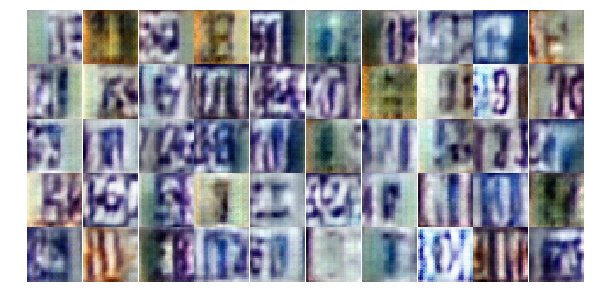

Epoch 9/10... Discriminator Loss: 1.0111... Generator Loss: 1.3828
Epoch 9/10... Discriminator Loss: 1.3335... Generator Loss: 1.3307
Epoch 9/10... Discriminator Loss: 1.8671... Generator Loss: 1.8187
Epoch 9/10... Discriminator Loss: 1.1583... Generator Loss: 0.7065
Epoch 9/10... Discriminator Loss: 1.1760... Generator Loss: 0.6790
Epoch 9/10... Discriminator Loss: 1.3584... Generator Loss: 1.2857
Epoch 9/10... Discriminator Loss: 1.2171... Generator Loss: 0.6658
Epoch 9/10... Discriminator Loss: 1.0018... Generator Loss: 0.8593
Epoch 10/10... Discriminator Loss: 1.0808... Generator Loss: 1.1418
Epoch 10/10... Discriminator Loss: 1.2671... Generator Loss: 0.6069


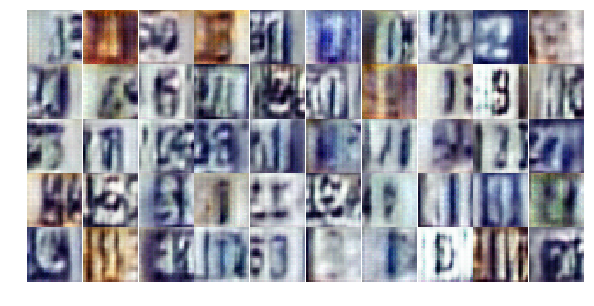

Epoch 10/10... Discriminator Loss: 1.1601... Generator Loss: 0.6625
Epoch 10/10... Discriminator Loss: 1.1457... Generator Loss: 0.6877
Epoch 10/10... Discriminator Loss: 1.3632... Generator Loss: 2.0878
Epoch 10/10... Discriminator Loss: 1.0145... Generator Loss: 1.2125
Epoch 10/10... Discriminator Loss: 1.0127... Generator Loss: 1.0441
Epoch 10/10... Discriminator Loss: 1.2019... Generator Loss: 1.1470
Epoch 10/10... Discriminator Loss: 1.1446... Generator Loss: 0.7976
Epoch 10/10... Discriminator Loss: 1.2394... Generator Loss: 0.5391
Epoch 10/10... Discriminator Loss: 0.9495... Generator Loss: 1.1422
Epoch 10/10... Discriminator Loss: 0.8180... Generator Loss: 1.2084


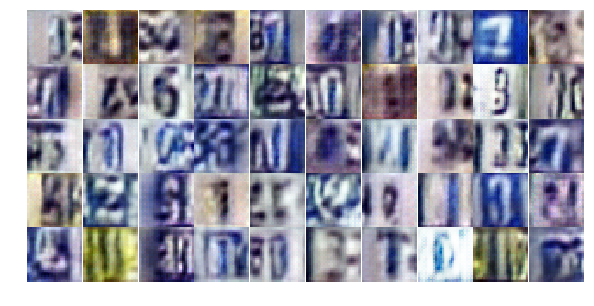

Epoch 10/10... Discriminator Loss: 1.2218... Generator Loss: 1.1758
Epoch 10/10... Discriminator Loss: 1.1468... Generator Loss: 0.6406
Epoch 10/10... Discriminator Loss: 1.2630... Generator Loss: 0.5805
Epoch 10/10... Discriminator Loss: 0.9896... Generator Loss: 0.8077
Epoch 10/10... Discriminator Loss: 1.2111... Generator Loss: 0.7492
Epoch 10/10... Discriminator Loss: 1.1075... Generator Loss: 0.7387
Epoch 10/10... Discriminator Loss: 0.9369... Generator Loss: 0.8764
Epoch 10/10... Discriminator Loss: 1.0457... Generator Loss: 1.0312
Epoch 10/10... Discriminator Loss: 1.1140... Generator Loss: 0.8112
Epoch 10/10... Discriminator Loss: 1.0263... Generator Loss: 1.1946


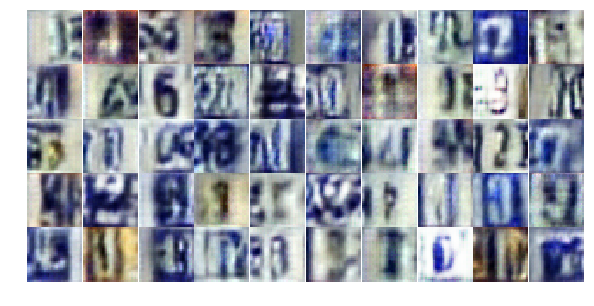

Epoch 10/10... Discriminator Loss: 1.3008... Generator Loss: 0.9619
Epoch 10/10... Discriminator Loss: 1.5301... Generator Loss: 0.4291
Epoch 10/10... Discriminator Loss: 1.5052... Generator Loss: 1.4223
Epoch 10/10... Discriminator Loss: 1.3354... Generator Loss: 0.5727
Epoch 10/10... Discriminator Loss: 0.9583... Generator Loss: 1.0233
Epoch 10/10... Discriminator Loss: 1.6960... Generator Loss: 0.9170
Epoch 10/10... Discriminator Loss: 1.0396... Generator Loss: 1.3987


In [17]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

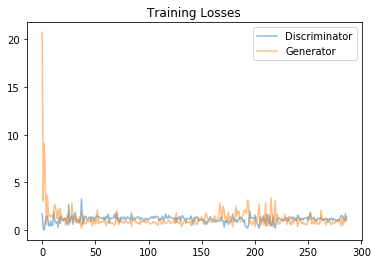

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

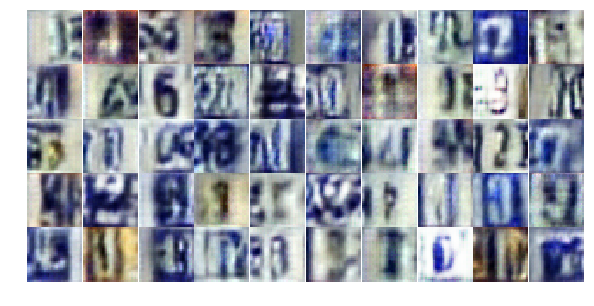

In [19]:
_ = view_samples(-1, samples, 5, 10, figsize=(10,5))